# Modelling CIFAR10 Dataset Using Resnet18 - Use LR Strategies
### The requirements in detail:
  

1. Pick your last code
2. Make sure  to Add CutOut to your code. It should come from your transformations (albumentations)
3. Use this repo: https://github.com/davidtvs/pytorch-lr-finder
    - Move LR Finder code to your modules
    - Implement LR Finder (for SGD, not for ADAM)
    - Implement ReduceLROnPlatea: https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.ReduceLROnPlateau
4. Find best LR to train your model
5. Use SDG with Momentum
6. Train for 50 Epochs. 
7. Show Training and Test Accuracy curves
8. Target 88% Accuracy.
9. Run GradCAM on the any 25 misclassified images. Make sure you mention what is the prediction and what was the ground truth label.
10. Submit


## Setup google drive for storage & retrieval

In [1]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

module_folder = 'drive/My Drive/eva_stored_from_colab/eva5/cifar10_lrfinder/'
github_path = "tsai_projects/assignment10_lrFinder/"
github_raw_models_path = "tsai_projects/assignment10_lrFinder/raw_models/"
github_custom_utils_path = "tsai_projects/assignment10_lrFinder/custom_utils/"


base_folder = module_folder+'trained_weights/'
anlt_folder = module_folder+'analysis_materials/'
acc_recorder_files = ["maxAcc_cifar10_lrfinder"]
model_file_names = ["mdl_cifar10_lrfinder"]

Mounted at /content/drive


## Get module from github & set it up for use

In [2]:
!rm -r tsai_projects/

In [3]:
!git clone  https://github.com/sairamsubramaniam/tsai_projects.git

Cloning into 'tsai_projects'...
remote: Enumerating objects: 403, done.
remote: Counting objects: 100% (403/403), done.
remote: Compressing objects: 100% (266/266), done.
remote: Total 403 (delta 224), reused 310 (delta 134), pack-reused 0
Receiving objects: 100% (403/403), 739.84 KiB | 2.02 MiB/s, done.
Resolving deltas: 100% (224/224), done.


# RESTART RUNTIME AFTER INSTALLING THE BELOW

In [4]:
!pip install -U git+https://github.com/albumentations-team/albumentations

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-4dlegmvt
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-4dlegmvt
  Created wheel for albumentations: filename=albumentations-0.4.6-cp36-none-any.whl size=69177 sha256=891555a157cfa488de877910553f50a9798c3d4fdeb9035a831f74a176ebe3ea
  Stored in directory: /tmp/pip-ephem-wheel-cache-a21m8wi_/wheels/6f/77/82/86baf8aeda64a6de0f890cd0f2fb31acaf5545cc9c99ad21ba
Successfully built albumentations
  Found existing installation: albumentations 0.4.6
    Uninstalling albumentations-0.4.6:
      Successfully uninstalled albumentations-0.4.6


## Import all the required modules including the custom ones

In [5]:
from __future__ import print_function
from operator import itemgetter
import time
import sys
# sys.path.append(module_folder)
sys.path.append(github_path)
sys.path.append(github_raw_models_path)
sys.path.append(github_custom_utils_path)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
%matplotlib inline

from raw_models import resnets
import custom_utils
from custom_utils import helpers
from custom_utils import analytics
from custom_utils import preprocessors as prep
from custom_utils import lrfinder
from custom_utils.lrfinder import lr_finder

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

## Download Data

In [6]:
train_loader, test_loader, classes = prep.get_cifar10_loaders(root="./data", device=device)

Files already downloaded and verified
[(0.4913995563983917, 0.48215845227241516, 0.44653093814849854), (0.20230083167552948, 0.19941286742687225, 0.20096157491207123)]
Files already downloaded and verified


## Find Best LR to start with

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.00E+01



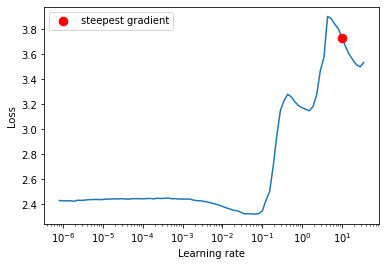

In [7]:
model = resnets.ResNet18().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-7, weight_decay=0.0005)
lr_finder = lr_finder.LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=100, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

## Training - 50 Epochs
All of the initial LRs suggested by LR Finder didnt work at all!! Since 0.1 has proven to be the best lr from all the previous assignments and we have a target of 88%, we use 0.1 as the starting LR below coupled with ReduceLrOnPlateau.  
 
Augmentations include cutout, rotate, horizontal-flip and normalize

In [8]:
fn_idx = 0
epochs = 50

acc_recorder_file = acc_recorder_files[fn_idx]
model_file_name = model_file_names[fn_idx]

accuracy_store_path = base_folder+acc_recorder_file
model_sd_save_path = base_folder+model_file_name+"_sd.pth"

model = resnets.ResNet18().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, weight_decay=0.0005, momentum=0.9)
sched = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, 
                                                                             patience=3, threshold=0.01, threshold_mode='abs', 
                                                                             cooldown=0, min_lr=0.0001, eps=1e-08, verbose=True)
loss_func = F.cross_entropy

trial1 = helpers.train_epochs(
                    model=model, 
                    device=device, 
                    train_loader=train_loader,
                    test_loader=test_loader, 
                    optimizer=optimizer, 
                    auto_scheduler=sched,
                    loss_func=loss_func, 
                    epochs=epochs,
                    accuracy_store_path=accuracy_store_path, 
                    model_sd_save_path=model_sd_save_path,
                    save_if_better_acc=True)

  0%|          | 0/391 [00:00<?, ?it/s]


LAST RECORDED MAX ACCURACY:  0.8561

EPOCH NUM 1


loss=1.496948003768921 batch_id=390: 100%|██████████| 391/391 [00:30<00:00, 12.84it/s]


Train Data: Average loss: 0.0153, Accuracy: 15945/50000 (31.8900%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.5220, Accuracy: 4392/10000 (43.9200%)

-----------------------------------------------

EPOCH NUM 2


loss=1.2323565483093262 batch_id=390: 100%|██████████| 391/391 [00:30<00:00, 12.94it/s]


Train Data: Average loss: 0.0110, Accuracy: 24244/50000 (48.4880%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.2222, Accuracy: 5506/10000 (55.0600%)

-----------------------------------------------

EPOCH NUM 3


loss=1.2601205110549927 batch_id=390: 100%|██████████| 391/391 [00:30<00:00, 12.85it/s]


Train Data: Average loss: 0.0090, Accuracy: 29510/50000 (59.0200%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.1995, Accuracy: 5861/10000 (58.6100%)

-----------------------------------------------

EPOCH NUM 4


loss=0.6941806077957153 batch_id=390: 100%|██████████| 391/391 [00:30<00:00, 12.90it/s]


Train Data: Average loss: 0.0076, Accuracy: 32826/50000 (65.6520%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.8827, Accuracy: 6930/10000 (69.3000%)

-----------------------------------------------

EPOCH NUM 5


loss=0.7006239891052246 batch_id=390: 100%|██████████| 391/391 [00:30<00:00, 12.87it/s]


Train Data: Average loss: 0.0066, Accuracy: 34992/50000 (69.9840%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.8126, Accuracy: 7129/10000 (71.2900%)

-----------------------------------------------

EPOCH NUM 6


loss=0.7956352233886719 batch_id=390: 100%|██████████| 391/391 [00:30<00:00, 12.86it/s]


Train Data: Average loss: 0.0057, Accuracy: 36988/50000 (73.9760%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.7617, Accuracy: 7422/10000 (74.2200%)

-----------------------------------------------

EPOCH NUM 7


loss=0.8036147356033325 batch_id=390: 100%|██████████| 391/391 [00:30<00:00, 12.95it/s]


Train Data: Average loss: 0.0051, Accuracy: 38700/50000 (77.4000%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.7381, Accuracy: 7516/10000 (75.1600%)

-----------------------------------------------

EPOCH NUM 8


loss=0.7083061337471008 batch_id=390: 100%|██████████| 391/391 [00:30<00:00, 12.93it/s]


Train Data: Average loss: 0.0047, Accuracy: 39532/50000 (79.0640%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.7089, Accuracy: 7579/10000 (75.7900%)

-----------------------------------------------

EPOCH NUM 9


loss=0.5986336469650269 batch_id=390: 100%|██████████| 391/391 [00:30<00:00, 12.95it/s]


Train Data: Average loss: 0.0044, Accuracy: 40271/50000 (80.5420%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.7289, Accuracy: 7548/10000 (75.4800%)

-----------------------------------------------

EPOCH NUM 10


loss=0.5971336960792542 batch_id=390: 100%|██████████| 391/391 [00:30<00:00, 12.90it/s]


Train Data: Average loss: 0.0041, Accuracy: 40854/50000 (81.7080%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.7464, Accuracy: 7514/10000 (75.1400%)

-----------------------------------------------

EPOCH NUM 11


loss=0.5483687520027161 batch_id=390: 100%|██████████| 391/391 [00:30<00:00, 12.90it/s]


Train Data: Average loss: 0.0039, Accuracy: 41224/50000 (82.4480%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5759, Accuracy: 8000/10000 (80.0000%)

-----------------------------------------------

EPOCH NUM 12


loss=0.7271869778633118 batch_id=390: 100%|██████████| 391/391 [00:30<00:00, 12.88it/s]


Train Data: Average loss: 0.0037, Accuracy: 41747/50000 (83.4940%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5901, Accuracy: 7971/10000 (79.7100%)

-----------------------------------------------

EPOCH NUM 13


loss=0.4798184335231781 batch_id=390: 100%|██████████| 391/391 [00:30<00:00, 12.93it/s]


Train Data: Average loss: 0.0036, Accuracy: 42012/50000 (84.0240%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5872, Accuracy: 8080/10000 (80.8000%)

-----------------------------------------------

EPOCH NUM 14


loss=0.6273051500320435 batch_id=390: 100%|██████████| 391/391 [00:30<00:00, 12.99it/s]


Train Data: Average loss: 0.0035, Accuracy: 42275/50000 (84.5500%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5503, Accuracy: 8173/10000 (81.7300%)

-----------------------------------------------

EPOCH NUM 15


loss=0.41494274139404297 batch_id=390: 100%|██████████| 391/391 [00:30<00:00, 12.93it/s]


Train Data: Average loss: 0.0034, Accuracy: 42565/50000 (85.1300%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6819, Accuracy: 7846/10000 (78.4600%)

-----------------------------------------------

EPOCH NUM 16


loss=0.47496190667152405 batch_id=390: 100%|██████████| 391/391 [00:30<00:00, 12.92it/s]


Train Data: Average loss: 0.0033, Accuracy: 42668/50000 (85.3360%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5328, Accuracy: 8191/10000 (81.9100%)

-----------------------------------------------

EPOCH NUM 17


loss=0.4855577349662781 batch_id=390: 100%|██████████| 391/391 [00:30<00:00, 13.00it/s]


Train Data: Average loss: 0.0032, Accuracy: 42838/50000 (85.6760%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5892, Accuracy: 8035/10000 (80.3500%)

-----------------------------------------------

EPOCH NUM 18


loss=0.2584272027015686 batch_id=390: 100%|██████████| 391/391 [00:30<00:00, 13.02it/s]


Train Data: Average loss: 0.0032, Accuracy: 42948/50000 (85.8960%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5380, Accuracy: 8175/10000 (81.7500%)

Epoch    18: reducing learning rate of group 0 to 1.0000e-02.
-----------------------------------------------

EPOCH NUM 19


loss=0.12665021419525146 batch_id=390: 100%|██████████| 391/391 [00:30<00:00, 13.00it/s]


Train Data: Average loss: 0.0018, Accuracy: 46278/50000 (92.5560%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3080, Accuracy: 8944/10000 (89.4400%)

-----------------------------------------------

EPOCH NUM 20


loss=0.17296940088272095 batch_id=390: 100%|██████████| 391/391 [00:30<00:00, 12.99it/s]


Train Data: Average loss: 0.0013, Accuracy: 47292/50000 (94.5840%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3017, Accuracy: 8997/10000 (89.9700%)

-----------------------------------------------

EPOCH NUM 21


loss=0.0646328404545784 batch_id=390: 100%|██████████| 391/391 [00:29<00:00, 13.04it/s]


Train Data: Average loss: 0.0011, Accuracy: 47745/50000 (95.4900%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3000, Accuracy: 9002/10000 (90.0200%)

-----------------------------------------------

EPOCH NUM 22


loss=0.2500857710838318 batch_id=390: 100%|██████████| 391/391 [00:30<00:00, 12.98it/s]


Train Data: Average loss: 0.0010, Accuracy: 48012/50000 (96.0240%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3021, Accuracy: 9011/10000 (90.1100%)

-----------------------------------------------

EPOCH NUM 23


loss=0.08372311294078827 batch_id=390: 100%|██████████| 391/391 [00:30<00:00, 12.94it/s]


Train Data: Average loss: 0.0008, Accuracy: 48279/50000 (96.5580%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3047, Accuracy: 9044/10000 (90.4400%)

Epoch    23: reducing learning rate of group 0 to 1.0000e-03.
-----------------------------------------------

EPOCH NUM 24


loss=0.1259540617465973 batch_id=390: 100%|██████████| 391/391 [00:30<00:00, 13.02it/s]


Train Data: Average loss: 0.0007, Accuracy: 48555/50000 (97.1100%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.2951, Accuracy: 9051/10000 (90.5100%)

-----------------------------------------------

EPOCH NUM 25


loss=0.06613749265670776 batch_id=390: 100%|██████████| 391/391 [00:29<00:00, 13.07it/s]


Train Data: Average loss: 0.0007, Accuracy: 48678/50000 (97.3560%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.2950, Accuracy: 9055/10000 (90.5500%)

-----------------------------------------------

EPOCH NUM 26


loss=0.06443129479885101 batch_id=390: 100%|██████████| 391/391 [00:29<00:00, 13.04it/s]


Train Data: Average loss: 0.0007, Accuracy: 48655/50000 (97.3100%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.2932, Accuracy: 9048/10000 (90.4800%)

-----------------------------------------------

EPOCH NUM 27


loss=0.07577747106552124 batch_id=390: 100%|██████████| 391/391 [00:29<00:00, 13.05it/s]


Train Data: Average loss: 0.0006, Accuracy: 48706/50000 (97.4120%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.2926, Accuracy: 9065/10000 (90.6500%)

-----------------------------------------------

EPOCH NUM 28


loss=0.09769891947507858 batch_id=390: 100%|██████████| 391/391 [00:29<00:00, 13.04it/s]


Train Data: Average loss: 0.0006, Accuracy: 48766/50000 (97.5320%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.2930, Accuracy: 9061/10000 (90.6100%)

Epoch    28: reducing learning rate of group 0 to 1.0000e-04.
-----------------------------------------------

EPOCH NUM 29


loss=0.04261401295661926 batch_id=390: 100%|██████████| 391/391 [00:29<00:00, 13.06it/s]


Train Data: Average loss: 0.0006, Accuracy: 48763/50000 (97.5260%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.2935, Accuracy: 9060/10000 (90.6000%)

-----------------------------------------------

EPOCH NUM 30


loss=0.15188927948474884 batch_id=390: 100%|██████████| 391/391 [00:29<00:00, 13.05it/s]


Train Data: Average loss: 0.0006, Accuracy: 48849/50000 (97.6980%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.2927, Accuracy: 9068/10000 (90.6800%)

-----------------------------------------------

EPOCH NUM 31


loss=0.03860665112733841 batch_id=390: 100%|██████████| 391/391 [00:30<00:00, 13.02it/s]


Train Data: Average loss: 0.0006, Accuracy: 48772/50000 (97.5440%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.2937, Accuracy: 9057/10000 (90.5700%)

-----------------------------------------------

EPOCH NUM 32


loss=0.04599577561020851 batch_id=390: 100%|██████████| 391/391 [00:30<00:00, 13.02it/s]


Train Data: Average loss: 0.0006, Accuracy: 48821/50000 (97.6420%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.2937, Accuracy: 9057/10000 (90.5700%)

-----------------------------------------------

EPOCH NUM 33


loss=0.04845023900270462 batch_id=390: 100%|██████████| 391/391 [00:29<00:00, 13.09it/s]


Train Data: Average loss: 0.0006, Accuracy: 48819/50000 (97.6380%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.2932, Accuracy: 9064/10000 (90.6400%)

-----------------------------------------------

EPOCH NUM 34


loss=0.055183302611112595 batch_id=390: 100%|██████████| 391/391 [00:29<00:00, 13.12it/s]


Train Data: Average loss: 0.0006, Accuracy: 48855/50000 (97.7100%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.2926, Accuracy: 9065/10000 (90.6500%)

-----------------------------------------------

EPOCH NUM 35


loss=0.05165418982505798 batch_id=390: 100%|██████████| 391/391 [00:29<00:00, 13.13it/s]


Train Data: Average loss: 0.0006, Accuracy: 48792/50000 (97.5840%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.2918, Accuracy: 9060/10000 (90.6000%)

-----------------------------------------------

EPOCH NUM 36


loss=0.0737556666135788 batch_id=390: 100%|██████████| 391/391 [00:30<00:00, 13.02it/s]


Train Data: Average loss: 0.0006, Accuracy: 48754/50000 (97.5080%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.2914, Accuracy: 9061/10000 (90.6100%)

-----------------------------------------------

EPOCH NUM 37


loss=0.16643330454826355 batch_id=390: 100%|██████████| 391/391 [00:29<00:00, 13.06it/s]


Train Data: Average loss: 0.0006, Accuracy: 48818/50000 (97.6360%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.2911, Accuracy: 9068/10000 (90.6800%)

-----------------------------------------------

EPOCH NUM 38


loss=0.07773620635271072 batch_id=390: 100%|██████████| 391/391 [00:29<00:00, 13.14it/s]


Train Data: Average loss: 0.0006, Accuracy: 48841/50000 (97.6820%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.2915, Accuracy: 9061/10000 (90.6100%)

-----------------------------------------------

EPOCH NUM 39


loss=0.06334210932254791 batch_id=390: 100%|██████████| 391/391 [00:30<00:00, 13.03it/s]


Train Data: Average loss: 0.0006, Accuracy: 48839/50000 (97.6780%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.2926, Accuracy: 9059/10000 (90.5900%)

-----------------------------------------------

EPOCH NUM 40


loss=0.04667123034596443 batch_id=390: 100%|██████████| 391/391 [00:30<00:00, 13.00it/s]


Train Data: Average loss: 0.0006, Accuracy: 48843/50000 (97.6860%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.2919, Accuracy: 9062/10000 (90.6200%)

-----------------------------------------------

EPOCH NUM 41


loss=0.08633251488208771 batch_id=390: 100%|██████████| 391/391 [00:29<00:00, 13.10it/s]


Train Data: Average loss: 0.0006, Accuracy: 48852/50000 (97.7040%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.2920, Accuracy: 9045/10000 (90.4500%)

-----------------------------------------------

EPOCH NUM 42


loss=0.060433872044086456 batch_id=390: 100%|██████████| 391/391 [00:29<00:00, 13.08it/s]


Train Data: Average loss: 0.0006, Accuracy: 48841/50000 (97.6820%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.2920, Accuracy: 9062/10000 (90.6200%)

-----------------------------------------------

EPOCH NUM 43


loss=0.06176195293664932 batch_id=390: 100%|██████████| 391/391 [00:29<00:00, 13.13it/s]


Train Data: Average loss: 0.0006, Accuracy: 48861/50000 (97.7220%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.2906, Accuracy: 9073/10000 (90.7300%)

-----------------------------------------------

EPOCH NUM 44


loss=0.04480556398630142 batch_id=390: 100%|██████████| 391/391 [00:29<00:00, 13.07it/s]


Train Data: Average loss: 0.0006, Accuracy: 48828/50000 (97.6560%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.2914, Accuracy: 9069/10000 (90.6900%)

-----------------------------------------------

EPOCH NUM 45


loss=0.08697366714477539 batch_id=390: 100%|██████████| 391/391 [00:30<00:00, 13.03it/s]


Train Data: Average loss: 0.0006, Accuracy: 48749/50000 (97.4980%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.2906, Accuracy: 9058/10000 (90.5800%)

-----------------------------------------------

EPOCH NUM 46


loss=0.14687249064445496 batch_id=390: 100%|██████████| 391/391 [00:29<00:00, 13.12it/s]


Train Data: Average loss: 0.0006, Accuracy: 48814/50000 (97.6280%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.2919, Accuracy: 9068/10000 (90.6800%)

-----------------------------------------------

EPOCH NUM 47


loss=0.10374715179204941 batch_id=390: 100%|██████████| 391/391 [00:30<00:00, 13.03it/s]


Train Data: Average loss: 0.0006, Accuracy: 48898/50000 (97.7960%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.2916, Accuracy: 9064/10000 (90.6400%)

-----------------------------------------------

EPOCH NUM 48


loss=0.0302666537463665 batch_id=390: 100%|██████████| 391/391 [00:29<00:00, 13.09it/s]


Train Data: Average loss: 0.0006, Accuracy: 48887/50000 (97.7740%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.2901, Accuracy: 9069/10000 (90.6900%)

-----------------------------------------------

EPOCH NUM 49


loss=0.08480825275182724 batch_id=390: 100%|██████████| 391/391 [00:29<00:00, 13.05it/s]


Train Data: Average loss: 0.0006, Accuracy: 48857/50000 (97.7140%)




Test set: Average loss: 0.2917, Accuracy: 9068/10000 (90.6800%)

-----------------------------------------------
TOTAL TRAINING TIME:  1570.8255171775818
LAST 10 EPOCH AVG ACC:  0.9063800000000001
LAST 5 EPOCH AVG ACC:  0.90654
MAX ACCURACY:  0.9073


## LOSS & ACCURACY CURVES

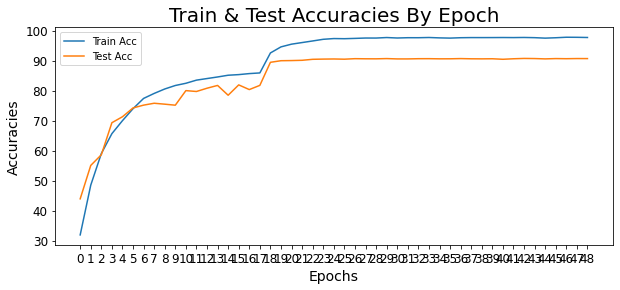

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 4))

xaxis = list(range(len(trial1["test_accuracies"])))
test_acc = [x*100 for x in trial1["test_accuracies"]]

axes.plot(xaxis, trial1["train_accuracies"], label="Train Acc")
axes.plot(xaxis, test_acc, label="Test Acc")
axes.set_title("Train & Test Accuracies By Epoch", fontsize=20)
axes.set_xlabel("Epochs", fontsize=14)
axes.set_ylabel("Accuracies", fontsize=14)
axes.set_xticks(xaxis)
axes.tick_params(axis='both', which='major', labelsize=12)
axes.legend()


plt.savefig(anlt_folder+"train_test_acc_chart.png")


# GRADCAM

In [10]:
rldd_model = resnets.ResNet18().to(device)
model_path = base_folder+model_file_names[-1]+"_sd.pth"
rldd_model.load_state_dict(torch.load(model_path))

imgs = []
targets = []
preds = []
for img, target in test_loader:
    imgs.append( img.to(device) )
    targets.append( target.to(device) )
    preds.append( torch.argmax(rldd_model(img.to(device)), dim=1) )

imgs = torch.cat(imgs, dim=0)
targets = torch.cat(targets, dim=0)
preds = torch.cat(preds, dim=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

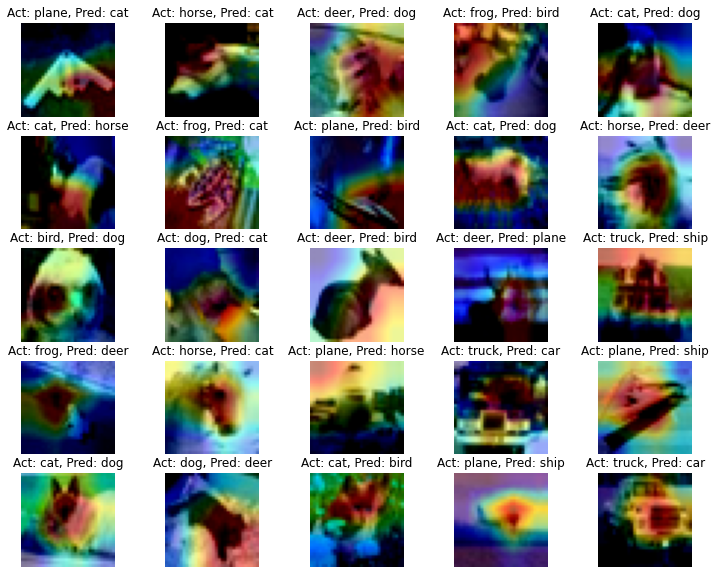

In [11]:
g_params = {"model": rldd_model, "feature_module": rldd_model.layer4, "target_layers": ["1"], "device": device}
fig, axes = analytics.plot_misclassified(imgs.cpu(), targets.cpu(), preds.cpu(), nrows=5, ncols=5, skip=0,
                       plt_scaler=(2,2.5), plt_fsize=12, classes=classes, gradcam_params=g_params)

In [12]:
fig.savefig(anlt_folder+"misclassified_gradcam.png")